In [ ]:
!pip install pyspark

### ⛳ Getting the data from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### ▶ Loading the data and showing the first 10

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit

# Start Spark session
spark = SparkSession.builder.appName("Salary Analysis").getOrCreate()

# Define file paths
path_2012 = '/content/drive/MyDrive/Colab Notebooks/brazil_salaries_data/2012_merged.csv'
path_2013 = '/content/drive/MyDrive/Colab Notebooks/brazil_salaries_data/2013_merged.csv'

# Read CSVs using the correct semicolon separator
df_2012 = spark.read.csv(path_2012, header=True, inferSchema=True, sep=';')
df_2013 = spark.read.csv(path_2013, header=True, inferSchema=True, sep=';')

# Optional: Add year column to each
df_2012 = df_2012.withColumn("YEAR", lit(2012))
df_2013 = df_2013.withColumn("YEAR", lit(2013))

# Merge datasets
combined_df = df_2012.unionByName(df_2013)

# Show result
combined_df.show(10)


+--------------------+--------------------+-----------+-----------+---------+--------------------+------+----+
|                NAME|          DEPARTMENT|MONTH_TOTAL|GROSS_TOTAL|NET_TOTAL|            POSITION| MONTH|YEAR|
+--------------------+--------------------+-----------+-----------+---------+--------------------+------+----+
|AAIRON TELES DE C...|   SEGURANCA PUBLICA|    1196,63|    1196,63|   720,66|OFICIAL ADMINISTR...|AUGUST|2012|
|AARAN ESTEVAO LIM...|POLICIA MILITAR E...|    5445,61|    7092,66|  5054,20|            2TEN  PM|AUGUST|2012|
|   AARAO DE OLIVEIRA|POLICIA MILITAR E...|   11344,51|   11344,51|  6451,63|            MAJ   PM|AUGUST|2012|
|AARON DE OLIVEIRA...|HOSPITAL DAS CLIN...|    4024,46|    4024,46|  3386,58|AGENTE TECNICO AS...|AUGUST|2012|
|AARON GABRIEL MIR...|SAO PAULO PREVIDE...|    1189,26|    2212,06|  2212,06|BENEFICIARIO DE S...|AUGUST|2012|
|AARON LUCAS MOLIN...|POLICIA MILITAR E...|    2597,90|    2597,90|  2293,59|            SD 2C PM|AUGUST|2012|
|

### ⚓ Importin the functions and methods we will use throught this file

In [ ]:
from pyspark.sql.functions import upper, col, avg, sum, regexp_replace, create_map, lit
from itertools import chain

### 🍃 Cleaning the data from string to number

In [ ]:
# Clean and convert GROSS_TOTAL and NET_TOTAL from string to double
combined_df = combined_df.withColumn("GROSS_TOTAL", regexp_replace("GROSS_TOTAL", "[.]", ""))
combined_df = combined_df.withColumn("GROSS_TOTAL", regexp_replace("GROSS_TOTAL", ",", ".").cast("double"))

combined_df = combined_df.withColumn("NET_TOTAL", regexp_replace("NET_TOTAL", "[.]", ""))
combined_df = combined_df.withColumn("NET_TOTAL", regexp_replace("NET_TOTAL", ",", ".").cast("double"))

combined_df = combined_df.withColumn("MONTH_TOTAL", regexp_replace("MONTH_TOTAL", "[.]", ""))
combined_df = combined_df.withColumn("MONTH_TOTAL", regexp_replace("MONTH_TOTAL", ",", ".").cast("double"))

In [ ]:
cleaned_df = combined_df.filter(col("NET_TOTAL").isNotNull())

In [ ]:
cleaned_df.show(10)

+--------------------+--------------------+-----------+-----------+---------+--------------------+------+----+
|                NAME|          DEPARTMENT|MONTH_TOTAL|GROSS_TOTAL|NET_TOTAL|            POSITION| MONTH|YEAR|
+--------------------+--------------------+-----------+-----------+---------+--------------------+------+----+
|AAIRON TELES DE C...|   SEGURANCA PUBLICA|    1196.63|    1196.63|   720.66|OFICIAL ADMINISTR...|AUGUST|2012|
|AARAN ESTEVAO LIM...|POLICIA MILITAR E...|    5445.61|    7092.66|   5054.2|            2TEN  PM|AUGUST|2012|
|   AARAO DE OLIVEIRA|POLICIA MILITAR E...|   11344.51|   11344.51|  6451.63|            MAJ   PM|AUGUST|2012|
|AARON DE OLIVEIRA...|HOSPITAL DAS CLIN...|    4024.46|    4024.46|  3386.58|AGENTE TECNICO AS...|AUGUST|2012|
|AARON GABRIEL MIR...|SAO PAULO PREVIDE...|    1189.26|    2212.06|  2212.06|BENEFICIARIO DE S...|AUGUST|2012|
|AARON LUCAS MOLIN...|POLICIA MILITAR E...|     2597.9|     2597.9|  2293.59|            SD 2C PM|AUGUST|2012|
|

### 🔍 Step 4: Data Exploration & Validation

Before proceeding with analysis, we'll:
- Check for nulls in key columns
- Print schema and row/column counts
- Get descriptive statistics\

In [ ]:
# Show schema
combined_df.printSchema()

# Count rows and columns
print(f"Rows: {combined_df.count()}, Columns: {len(combined_df.columns)}")

# Check for nulls
for col_name in ["GROSS_TOTAL", "NET_TOTAL", "MONTH_TOTAL", "DEPARTMENT"]:
    print(f"Nulls in {col_name}: {combined_df.filter(col(col_name).isNull()).count()}")

# Get descriptive statistics
combined_df.select("GROSS_TOTAL", "NET_TOTAL", "MONTH_TOTAL").describe().show()

+--------------------+--------------------+-----------+-----------+---------+--------------------+---------+----+-----+
|                NAME|          DEPARTMENT|MONTH_TOTAL|GROSS_TOTAL|NET_TOTAL|            POSITION|    MONTH|YEAR|count|
+--------------------+--------------------+-----------+-----------+---------+--------------------+---------+----+-----+
|ADANIZA DEOLINDA ...|SAO PAULO PREVIDE...|    1440,90|     1440.9|   1440.9|BENEFICIARIO DE S...|     JULY|2012|    2|
|RAFAEL SILVA DOMI...|            EDUCACAO|    1644,51|    1644.51|  1364.59|PROFESSOR EDUCACA...|   AUGUST|2012|    2|
|ROSEMARY CARVALHO...|SAO PAULO PREVIDE...|     311,00|      311.0|    311.0|BENEFICIARIO DE S...|   AUGUST|2012|    2|
|ELOINA CARVALHO L...|SAO PAULO PREVIDE...|    1315,61|    1315.61|  1238.54|BENEFICIARIO DE S...|   AUGUST|2012|    2|
|KELLLY CRISTINA R...|            EDUCACAO|     783,09|     783.09|   665.64|PROFESSOR EDUCACA...|   AUGUST|2012|    2|
|TELMA RODRIGUES PUPO|SAO PAULO PREVIDE.

📊 Top 1% Earners: Detecting Outliers

In this step, we identify employees in the top 1% of net salaries by calculating the approximate 99th percentile for `NET_TOTAL`.

This helps detect potential outliers or unusually high salaries that may require special attention or indicate data inconsistencies.

We use `approxQuantile()` to efficiently compute this percentile in large datasets, and then filter to inspect those cases.


In [ ]:
# b. Find top 1% salary values for further inspection
# Approximate 99th percentile for NET_TOTAL to identify top 1% earners
quantile_99 = combined_df.approxQuantile("NET_TOTAL", [0.99], 0.01)[0]
print(f"Approximate 99th percentile NET_TOTAL: {quantile_99}")

# Filters to only include rows where NET_TOTAL is greater than the 99th percentile and show
combined_df.filter(col("NET_TOTAL") >= quantile_99).show()

Approximate 99th percentile NET_TOTAL: 399898.8
+--------------------+--------------------+-----------+-----------+---------+--------------------+--------+----+
|                NAME|          DEPARTMENT|MONTH_TOTAL|GROSS_TOTAL|NET_TOTAL|            POSITION|   MONTH|YEAR|
+--------------------+--------------------+-----------+-----------+---------+--------------------+--------+----+
|TIAGO DE PAULA AR...|SAO PAULO PREVIDE...|    18725.0|  413459.52| 399898.8|AGENTE FISCAL DE ...|DECEMBER|2012|
+--------------------+--------------------+-----------+-----------+---------+--------------------+--------+----+



📆 Monthly Salary Trends (June to December)

This section analyzes how salary spending varies from June to December by calculating both:

- **Average net salary per month**
- **Total net salary expenditure per month**

To ensure accuracy and chronological sorting:
- We normalize month names to uppercase
- Filter only valid salary rows (non-null `NET_TOTAL`)
- Map month names to calendar numbers for proper ordering


In [ ]:
#4 How does salary vary across months from June to December?
  # Normalize MONTH to uppercase to ensure consistent matching
cleaned_df = cleaned_df.withColumn("MONTH", upper(col("MONTH")))

  # Filter out rows where NET_TOTAL is null (after the casting process)
cleaned_df = cleaned_df.filter(col("NET_TOTAL").isNotNull())

  # Define months of interest (June to December)
months_to_analyze= ["JUNE", "JULY", "AUGUST", "SEPTEMBER", "OCTOBER", "NOVEMBER", "DECEMBER"]

  # Create a mapping for month names to calendar months (for sorting by calendar order)
month_order = {
    "JUNE": 6,
    "JULY": 7,
    "AUGUST": 8,
    "SEPTEMBER": 9,
    "OCTOBER": 10,
    "NOVEMBER": 11,
    "DECEMBER": 12
}

  # Create a mapping expression for Spark
from pyspark.sql.functions import create_map, lit
mapping_expr = create_map([lit(x) for x in chain(*month_order.items())])

  # Add a new column MONTH_NUM based on the month name
df_with_month_num = cleaned_df.withColumn("MONTH_NUM", mapping_expr[col("MONTH")])

  # Filter the DataFrame to include only the months of interest (June to December) and aggregate
monthly_trend = df_with_month_num.filter(col("MONTH").isin(months_to_analyze)) \
    .groupBy("MONTH", "MONTH_NUM") \
    .agg(
        avg("NET_TOTAL").alias("AVG_NET_TOTAL"),  # Average monthly net salary
        sum("NET_TOTAL").alias("SUM_NET_TOTAL")   # Total monthly salary expenditure
    ) \
    .orderBy("MONTH_NUM")  # Sort by the calendar month number (June -> December)

  # Drop the MONTH_NUM column if you don't want it displayed
monthly_trend = monthly_trend.drop("MONTH_NUM")

  # Display the result
monthly_trend.show()

+---------+------------------+-------------------+
|    MONTH|     AVG_NET_TOTAL|      SUM_NET_TOTAL|
+---------+------------------+-------------------+
|     JUNE|2578.5395340175946|5.464386831159872E9|
|     JULY|2578.5161379017222|5.468331372100043E9|
|   AUGUST| 2683.223314754956|5.635048016210142E9|
|SEPTEMBER|2687.7715491632594|5.721088384230045E9|
|  OCTOBER|2575.0726408479536|5.494756952930025E9|
| NOVEMBER|2722.1449743316116|5.814199507080172E9|
| DECEMBER|3733.0477291560774|3.955839750679841E9|
+---------+------------------+-------------------+



📈 Average Monthly Net Salary (Visualization)

The line chart below illustrates how the **average net salary** changes from **June to December**.

This helps us visually identify any trends, peaks, or anomalies in monthly salary payments over the second half of the year.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

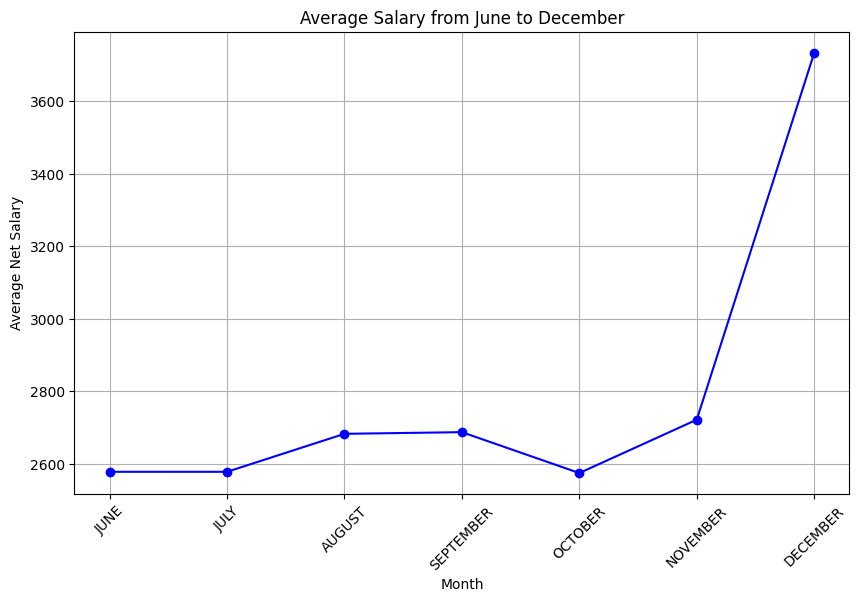

In [ ]:
# Convert to Pandas for plotting
monthly_trend_pd = monthly_trend.toPandas()

# Plot the average salary by month
plt.figure(figsize=(10, 6))
plt.plot(monthly_trend_pd['MONTH'], monthly_trend_pd['AVG_NET_TOTAL'], marker='o', color='b')
plt.title("Average Salary from June to December")
plt.xlabel("Month")
plt.ylabel("Average Net Salary")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

💰 Total Monthly Net Salary Expenditure (Visualization)

This chart shows the **total net salary spending** per month from **June to December**.

It helps identify how overall public expenditure fluctuates across the months, revealing potential seasonal spikes or reductions in payroll.


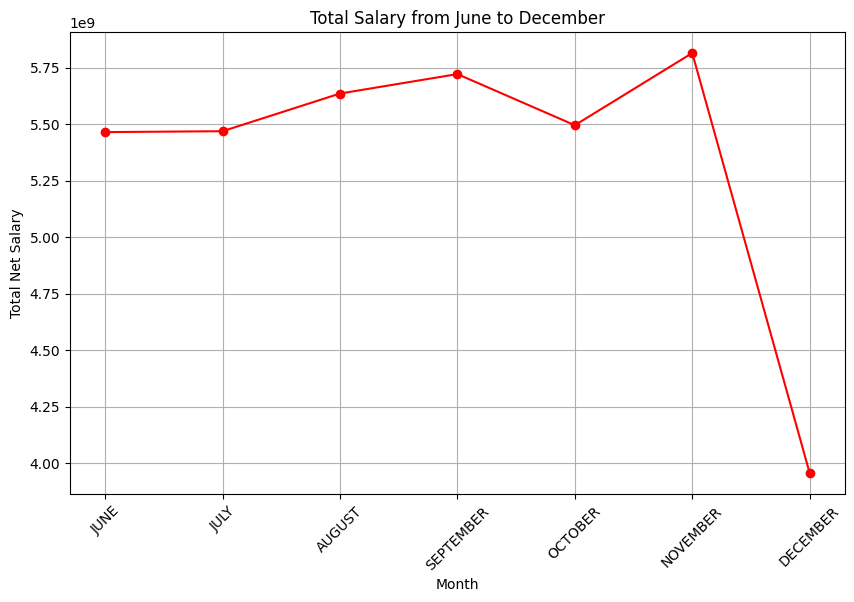

In [ ]:
# Convert to Pandas for plotting
monthly_trend_pd = monthly_trend.toPandas()

# Plot the total salary by month (SUM_NET_TOTAL)
plt.figure(figsize=(10, 6))
plt.plot(monthly_trend_pd['MONTH'], monthly_trend_pd['SUM_NET_TOTAL'], marker='o', color='r')
plt.title("Total Salary from June to December")
plt.xlabel("Month")
plt.ylabel("Total Net Salary")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

🏆 Salary Concentration: Top 10% Earners

In this step, we determine what **percentage of total public salary funds** went to the **top 10% highest-paid employees**.

The process involves:
- Sorting all employees by net salary (NET_TOTAL)
- Selecting the top 10% earners
- Calculating their total salary
- Comparing it against the overall salary pool

This gives us a sense of how **income is distributed** within the public sector and whether a significant portion is concentrated among a few individuals.


In [ ]:
# 6. What percentage of salary funds went to the top 10% earners?
# Sort by NET_TOTAL in descending order
sorted_df = cleaned_df.orderBy("NET_TOTAL", ascending=False)

# Calculate the total number of rows
total_rows = sorted_df.count()

# Calculate the number of rows representing the top 10%
top_10_rows_count = int(total_rows * 0.10)

# Take the top 10% earners based on sorted data
top_10_df = sorted_df.limit(top_10_rows_count)

# Calculate total NET_TOTAL for the top 10% earners
top_10_total = top_10_df.agg({"NET_TOTAL": "sum"}).first()[0]

# Calculate total NET_TOTAL paid to everyone
overall_total = cleaned_df.agg({"NET_TOTAL": "sum"}).first()[0]

# Calculate the percentage of total salary paid to the top 10% earners
percentage = (top_10_total / overall_total) * 100
print(f"Top 10% earners received approximately {percentage:.2f}% of total public salary funds.")

Top 10% earners received approximately 31.16% of total public salary funds.
